### 1. Import SpaceFlow and squidpy package

In [1]:
import warnings
warnings.filterwarnings('ignore')
import squidpy as sq
from SpaceFlow import SpaceFlow

### 2. Load the ST data from squidpy package

In [2]:
adata = sq.datasets.seqfish()

### 3. Create SpaceFlow Object

We create a SpaceFlow object using the count matrix of gene expression and the corresponding spatial locations of cells (or spots):

In [3]:
sf = SpaceFlow.SpaceFlow(expr_data=adata.X, 
                         spatial_locs=adata.obsm['spatial'])

Parameters:
- `expr_data`: the count matrix of gene expression, 2D numpy array of size (# of cells, # of genes)
- `spatial_locs`: spatial locations of cells (or spots) match to rows of the count matrix, 1D numpy array of size (n_locations,)

### 4. Preprocessing the ST Data
Next, we preprocess the ST data by run:

In [4]:
sf.preprocessing_data(n_top_genes=3000)

Parameters:
- `n_top_genes`: the number of the top highly variable genes.

The preprocessing includes the normalization and log-transformation of the expression count matrix, the selection of highly variable genes, and the construction of spatial proximity graph using spatial coordinates. (Details see the `preprocessing_data` function in `SpaceFlow/SpaceFlow.py`)


### 5. Train the deep graph network model

We then train a spatially regularized deep graph network model to learn a low-dimensional embedding that reflecting both expression similarity and the spatial proximity of cells in ST data.  


In [5]:
sf.train(spatial_regularization_strength=0.1, 
         z_dim=50, 
         lr=1e-3, 
         epochs=1000, 
         max_patience=50, 
         min_stop=100, 
         random_seed=42, 
         gpu=0, 
         regularization_acceleration=True, 
         edge_subset_sz=1000000)

Epoch 2/1000, Loss: 2.105508804321289
Epoch 12/1000, Loss: 1.3464184999465942
Epoch 22/1000, Loss: 1.09248685836792
Epoch 32/1000, Loss: 0.8551639914512634
Epoch 42/1000, Loss: 0.6653984189033508
Epoch 52/1000, Loss: 0.4879186451435089
Epoch 62/1000, Loss: 0.34967240691185
Epoch 72/1000, Loss: 0.274603009223938
Epoch 82/1000, Loss: 0.2149953991174698
Epoch 92/1000, Loss: 0.18800733983516693
Epoch 102/1000, Loss: 0.15587514638900757
Epoch 112/1000, Loss: 0.15160660445690155
Epoch 122/1000, Loss: 0.13229766488075256
Epoch 132/1000, Loss: 0.12213142216205597
Epoch 142/1000, Loss: 0.11389018595218658
Epoch 152/1000, Loss: 0.11026303470134735
Epoch 162/1000, Loss: 0.10858513414859772
Epoch 172/1000, Loss: 0.0981854647397995
Epoch 182/1000, Loss: 0.09261471033096313
Epoch 192/1000, Loss: 0.09784780442714691
Epoch 202/1000, Loss: 0.09372460097074509
Epoch 212/1000, Loss: 0.09502124786376953
Epoch 222/1000, Loss: 0.0898984745144844
Epoch 232/1000, Loss: 0.08758103847503662
Epoch 242/1000, Loss

array([[-1.3693943 , -0.1211542 ,  3.066468  , ..., -0.58150786,
        -0.12908368,  3.6877515 ],
       [-1.1312834 , -0.282027  ,  3.43263   , ..., -0.6431831 ,
        -0.0902295 ,  4.229353  ],
       [-1.0586573 ,  2.594063  ,  0.5477483 , ..., -0.2179767 ,
        -0.20996477,  1.9479373 ],
       ...,
       [-0.58471024,  2.330395  , -0.04218347, ..., -0.25748822,
         0.0110341 ,  1.8769083 ],
       [-0.8118924 ,  0.48114178,  3.4098723 , ..., -0.2737087 ,
         0.23058248,  2.079208  ],
       [-0.39583313,  1.7552938 ,  0.08656111, ..., -0.27222347,
         1.6503936 ,  1.3976719 ]], dtype=float32)

Parameters:
- `spatial_regularization_strength`: the strength of spatial regularization, the larger the more of the spatial coherence in the identified spatial domains and spatiotemporal patterns. (default: 0.1)
- `z_dim`: the target size of the learned embedding. (default: 50)
- `lr`: learning rate for optimizing the model. (default: 1e-3)
- `epochs`: the max number of the epochs for model training. (default: 1000)
- `max_patience`: the max number of the epoch for waiting the loss decreasing. If loss does not decrease for epochs larger than this threshold, the learning will stop, and the model with the parameters that shows the minimal loss are kept as the best model. (default: 50) 
- `min_stop`: the earliest epoch the learning can stop if no decrease in loss for epochs larger than the `max_patience`. (default: 100) 
- `random_seed`: the random seed set to the random generators of the `random`, `numpy`, `torch` packages. (default: 42)
-  `gpu`: the index of the Nvidia GPU, if no GPU, the model will be trained via CPU, which is slower than the GPU training time. (default: 0) 
-  `regularization_acceleration`: whether or not accelerate the calculation of regularization loss using edge subsetting strategy (default: True)
-  `edge_subset_sz`: the edge subset size for regularization acceleration (default: 1000000)

### 6. Domain segmentation of the ST data

After the model training, the learned low-dimensional embedding can be accessed through `sf.embedding`.

SpaceFlow will use this learned embedding to identify the spatial domains based on [Leiden](https://www.nature.com/articles/s41598-019-41695-z) algorithm. 


In [6]:
sf.segmentation(domain_label_save_filepath="./domains.tsv", 
                n_neighbors=50, 
                resolution=1.0)

Performing domain segmentation
Segmentation complete, domain labels of cells or spots saved at ./domains.tsv !


Parameters:

- `domain_label_save_filepath`: the file path for saving the identified domain labels. (default: "./domains.tsv")
- `n_neighbors`: the number of the nearest neighbors for each cell for constructing the graph for Leiden using the embedding as input. (default: 50)
- `resolution`: the resolution of the Leiden clustering, the larger the coarser of the domains. (default: 1.0)


### 7. Visualization of the identified spatial domains

We next plot the spatial domains using the identified domain labels and spatial coordinates of cells.

In [7]:
sf.plot_segmentation(segmentation_figure_save_filepath="./domain_segmentation.pdf", 
                     colormap="tab20", 
                     scatter_sz=1., 
                     rsz=4., 
                     csz=4., 
                     wspace=.4, 
                     hspace=.5, 
                     left=0.125, 
                     right=0.9, 
                     bottom=0.1, 
                     top=0.9)

Plotting complete, segmentation figure saved at ./domain_segmentation.pdf !


Parameters:
- `segmentation_figure_save_filepath`: optional, type: str, the file path for saving the figure of the spatial domain visualization. (default: "./domain_segmentation.pdf")
- `colormap`: optional, type: str, the colormap of the different domains, full colormap options see [matplotlib](https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html)
- `scatter_sz`: optional, type: float, the marker size in points. (default: 1.0)
- `rsz`: optional, type: float, row size of the figure in inches, (default: 4.0)
- `csz`: optional, type: float, column size of the figure in inches, (default: 4.0)
- `wspace`: optional, type: float, the amount of width reserved for space between subplots, expressed as a fraction of the average axis width (default: 0.4)
- `hspace`: optional, type: float,the amount of height reserved for space between subplots, expressed as a fraction of the average axis height (default: 0.4)
- `left`: optional, type: float, the leftmost position of the subplots of the figure in fraction (default: 0.125)
- `right`: optional, type: float, the rightmost position of the subplots of the figure in fraction (default: 0.9)
- `bottom`: optional, type: float, the bottom position of the subplots of the figure in fraction (default: 0.1)
- `top`: optional, type: float, the top position of the subplots of the figure in fraction (default: 0.9)


We can also visualize the expert annotation for comparison by:

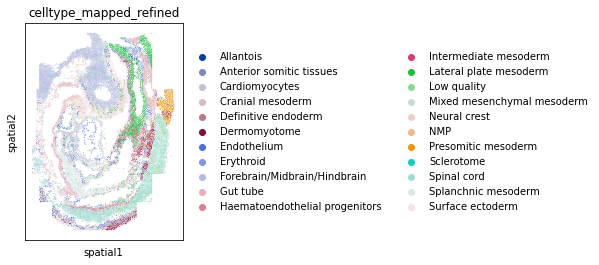

In [8]:
import scanpy as sc
sc.pl.spatial(adata, 
    color="celltype_mapped_refined",
    spot_size=0.03)

### 8. Idenfify the spatiotemporal patterns of the ST data through pseudo-Spatiotemporal Map (pSM)

Next, we apply the diffusion pseudotime (dpt) algorithm to the learned spatially-consistent embedding to generate a pseudo-Spatiotemporal Map (pSM). This pSM represents a spatially-coherent pseudotime ordering of cells that encodes biological relationships between cells, such as developmental trajectories and cancer progression


In [10]:
sf.pseudo_Spatiotemporal_Map(pSM_values_save_filepath="./pSM_values.tsv", 
                             n_neighbors=20, 
                             resolution=1.0)

Performing pseudo-Spatiotemporal Map
pseudo-Spatiotemporal Map(pSM) calculation complete, pSM values of cells or spots saved at ./pSM_values.tsv!


Parameters:
- `pSM_values_save_filepath` : the file path for saving the inferred pSM values. 
- `n_neighbors`: the number of the nearest neighbors for each cell for constructing the graph for Leiden using the embedding as input. (default: 20)  
- `resolution`: the resolution of the Leiden clustering, the larger the coarser of the domains. (default: 1.0)

### 9. Visualization of the identified pseudo-Spatiotemporal Map (pSM)

We next visualize the identified pseudo-Spatiotemporal Map (pSM).


In [ ]:
sf.plot_pSM(pSM_figure_save_filepath="./pseudo-Spatiotemporal-Map.pdf", 
            colormap="roma", 
            scatter_sz=1., 
            rsz=4., 
            csz=4., 
            wspace=.4, 
            hspace=.5, 
            left=0.125, 
            right=0.9, 
            bottom=0.1, 
            top=0.9)

Parameters:
- `pSM_figure_save_filepath`: optional, type: str, the file path for saving the figure of the pSM visualization. (default: "./pseudo-Spatiotemporal-Map.pdf")
- `colormap`:  optional, type: str, the colormap of the pSM (default: 'roma'), full colormap options see [Scientific Colormaps](https://www.fabiocrameri.ch/colourmaps-userguide/)
- `scatter_sz`:optional, type: float, the marker size in points. (default: 1.0)
- `rsz`: optional, type: float, row size of the figure in inches, (default: 4.0)
- `csz`: optional, type: float, column size of the figure in inches, (default: 4.0)
- `wspace`: optional, type: float, the amount of width reserved for space between subplots, expressed as a fraction of the average axis width (default: 0.4)
- `hspace`: optional, type: float,the amount of height reserved for space between subplots, expressed as a fraction of the average axis height (default: 0.4)
- `left`: optional, type: float, the leftmost position of the subplots of the figure in fraction (default: 0.125)
- `right`: optional, type: float, the rightmost position of the subplots of the figure in fraction (default: 0.9)
- `bottom`: optional, type: float, the bottom position of the subplots of the figure in fraction (default: 0.1)
- `top`: optional, type: float, the top position of the subplots of the figure in fraction (default: 0.9)
